# Model 7: CatBoost with All Features

This notebook trains an **CatBoost** classifier on all available features (regular + all embeddings) with comprehensive preprocessing:
- ✅ All regular features
- ✅ All embedding families (PCA-compressed)
- ✅ Feature scaling (StandardScaler)
- ✅ 5-fold Cross-Validation
- ✅ Comprehensive Hyperparameter Tuning (RandomizedSearchCV)
- ✅ Threshold Fine-tuning
- ✅ Model Saving
- ✅ Submission.csv Generation
- ✅ OOM Safe with aggressive memory management
- ✅ SMOTETomek for class imbalance

# 📑 Model 7 - Code Navigation Index

## Quick Navigation
- **[Setup](#1-setup)** - Imports, paths, device configuration, robustness utilities
- **[Data Loading](#2-data-loading--feature-extraction)** - Load and split features
- **[PCA Preprocessing](#3-feature-preprocessing-pca)** - Embedding compression (if applicable)
- **[SMOTETomek](#4-class-imbalance-handling-smotetomek)** - Class imbalance resampling
- **[Feature Scaling](#5-feature-scaling)** - StandardScaler normalization
- **[Cross-Validation](#6-cross-validation--hyperparameter-tuning)** - Hyperparameter optimization
- **[Threshold Tuning](#7-threshold-tuning--final-evaluation)** - Optimal threshold finding
- **[Model Saving](#8-save-model)** - Save model weights and metadata
- **[Submission](#9-generate-submission)** - Generate test predictions

## Model Type: CatBoost (all features)

## Key Features
✅ GPU-friendly with CPU fallback  
✅ Aggressive garbage collection  
✅ OOM resistant with chunked processing  
✅ Kernel panic resistant (signal handlers, checkpoints)  
✅ Polars-only (no pandas)  
✅ GPU-friendly PCA (IncrementalTorchPCA option)  
✅ SMOTETomek for class imbalance  
✅ Feature scaling & embedding normalization  
✅ Hyperparameter tuning (RandomizedSearchCV/GridSearchCV)  
✅ Fine-grained threshold optimization (120+ thresholds)  
✅ Model weights saved  
✅ Chunked/batched data processing  

## Memory Management
- `cleanup_memory()`: Aggressive GC + GPU cache clearing
- `check_memory_safe()`: Pre-operation memory checks
- `chunked_operation()`: Process large data in chunks
- `safe_operation()`: Retry decorator with OOM handling
- Signal handlers: SIGINT/SIGTERM for graceful shutdown
- Checkpoints: Resume from failures

## Device Handling
- Automatic GPU detection with CPU fallback
- `device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')`
- All tensors moved to device explicitly
- GPU cache cleared aggressively after operations


## 1. Setup

In [1]:
import os
from pathlib import Path
import random
import gc
import numpy as np
import polars as pl
import torch
from typing import Dict, Optional
import sys
import time
import json
import pickle
import signal
import atexit
from functools import wraps
from datetime import datetime


In [2]:
# =========================
# STARTUP & REPRODUCIBILITY
# =========================

TOTAL_START_TIME = time.time()
START_TIME_STR = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print(f"\n{'='*80}")
print("MODEL_CATBOOST EXECUTION STARTED")
print(f"Start Time: {START_TIME_STR}")
print(f"{'='*80}\n")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



MODEL_CATBOOST EXECUTION STARTED
Start Time: 2025-11-19 09:44:46



Using device: cuda


In [3]:
# ==============
# PATH MANAGEMENT
# ==============

current = Path(os.getcwd())
PROJECT_ROOT = current
for _ in range(5):
    if (PROJECT_ROOT / "data").exists():
        break
    PROJECT_ROOT = PROJECT_ROOT.parent
else:
    PROJECT_ROOT = current.parent.parent

MODEL_READY_DIR = PROJECT_ROOT / "data" / "model_ready"
MODEL_SAVE_DIR = PROJECT_ROOT / "models" / "saved_models"
SUBMISSION_DIR = PROJECT_ROOT / "data" / "submission_files"
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)
SUBMISSION_DIR.mkdir(parents=True, exist_ok=True)
utils_path = PROJECT_ROOT / "src" / "utils"
print("PROJECT_ROOT:", PROJECT_ROOT)
print("MODEL_READY_DIR:", MODEL_READY_DIR)

PROJECT_ROOT: /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2
MODEL_READY_DIR: /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/model_ready


In [4]:
# =======================
# PCA UTILITY IMPORTS
# =======================
USE_TORCH_PCA = False
if utils_path.exists():
    sys.path.insert(0, str(utils_path))

if USE_TORCH_PCA:
    try:
        from pca_utils import IncrementalTorchPCA
        IncrementalPCA = IncrementalTorchPCA
        IS_TORCH_PCA = True
        print("✅ Using PyTorch PCA (GPU-friendly)")
    except ImportError:
        from sklearn.decomposition import IncrementalPCA
        IS_TORCH_PCA = False
        print("⚠️ Using sklearn IncrementalPCA (CPU only)")
else:
    from sklearn.decomposition import IncrementalPCA
    IS_TORCH_PCA = False
    print("✅ Using sklearn IncrementalPCA (memory-efficient)")

✅ Using sklearn IncrementalPCA (memory-efficient)


In [5]:
# ==========
# ML LIBRARIES
# ==========
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, classification_report, precision_recall_curve, roc_curve, confusion_matrix
import catboost as cat
from catboost import CatBoostClassifier

# ==========
# VISUALIZATION LIBRARIES
# ==========
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [6]:
# ===============================
# MEMORY UTILITIES (FALLBACK DEFS)
# ===============================
try:
    from model_training_utils import cleanup_memory, memory_usage, check_memory_safe
    print("✅ Memory utilities imported from shared module")
except ImportError:
    def cleanup_memory():
        """Aggressive memory cleanup for both CPU and GPU."""
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
            torch.cuda.ipc_collect()
        gc.collect()
    
    def memory_usage():
        """Display current memory usage statistics."""
        try:
            import psutil
            process = psutil.Process(os.getpid())
            mem_gb = process.memory_info().rss / 1024**3
            print(f"💾 Memory: {mem_gb:.2f} GB (RAM)", end="")
            if torch.cuda.is_available():
                gpu_mem = torch.cuda.memory_allocated() / 1024**3
                gpu_reserved = torch.cuda.memory_reserved() / 1024**3
                print(f" | {gpu_mem:.2f}/{gpu_reserved:.2f} GB (GPU used/reserved)")
            else:
                print()
        except:
            pass
    
    def check_memory_safe(ram_threshold_gb=0.85, gpu_threshold=0.80):
        """Check if memory usage is safe for operations."""
        try:
            import psutil
            process = psutil.Process(os.getpid())
            ram_gb = process.memory_info().rss / 1024**3
            total_ram = psutil.virtual_memory().total / 1024**3
            ram_ratio = ram_gb / total_ram if total_ram > 0 else 0
            gpu_ratio = 0
            if torch.cuda.is_available():
                gpu_used = torch.cuda.memory_allocated() / 1024**3
                gpu_total = torch.cuda.get_device_properties(0).total_memory / 1024**3
                gpu_ratio = gpu_used / gpu_total if gpu_total > 0 else 0
            is_safe = ram_ratio < ram_threshold_gb and gpu_ratio < gpu_threshold
            return is_safe, {"ram_gb": ram_gb, "ram_ratio": ram_ratio, "gpu_ratio": gpu_ratio}
        except:
            return True, {}
    
    print("⚠️ Using fallback memory utilities")

memory_usage()

✅ Memory utilities imported from shared module
💾 Memory: 0.63 GB (RAM) | 0.00/0.00 GB (GPU used/reserved)


In [7]:
# ===============================
# ROBUSTNESS/CHECKPOINT UTILITIES
# ===============================

_checkpoint_state = {
    "pca_complete": False,
    "scaling_complete": False,
    "cv_complete": False,
    "final_model_trained": False,
    "last_saved_checkpoint": None,
}

def save_checkpoint(state_name: str, data: dict, checkpoint_dir: Path = None):
    """Save checkpoint to resume from failures."""
    if checkpoint_dir is None:
        checkpoint_dir = PROJECT_ROOT / "data" / "checkpoints"
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    checkpoint_path = checkpoint_dir / f"model_catboost_checkpoint_{state_name}.pkl"
    try:
        with open(checkpoint_path, "wb") as f:
            pickle.dump(data, f)
        _checkpoint_state["last_saved_checkpoint"] = checkpoint_path
        print(f"✅ Checkpoint saved: {checkpoint_path}")
    except Exception as e:
        print(f"⚠️ Failed to save checkpoint: {e}")

def load_checkpoint(state_name: str, checkpoint_dir: Path = None):
    """Load checkpoint to resume from failures."""
    if checkpoint_dir is None:
        checkpoint_dir = PROJECT_ROOT / "data" / "checkpoints"
    checkpoint_path = checkpoint_dir / f"model_catboost_checkpoint_{state_name}.pkl"
    if checkpoint_path.exists():
        try:
            with open(checkpoint_path, "rb") as f:
                data = pickle.load(f)
            print(f"✅ Checkpoint loaded: {checkpoint_path}")
            return data
        except Exception as e:
            print(f"⚠️ Failed to load checkpoint: {e}")
    return None

def safe_operation(operation_name: str, max_retries: int = 3, checkpoint_on_success: bool = False):
    """Decorator for safe operations with retry and checkpoint support."""
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            for attempt in range(max_retries):
                try:
                    is_safe, mem_info = check_memory_safe(ram_threshold_gb=0.80, gpu_threshold=0.75)
                    if not is_safe:
                        cleanup_memory()
                        if torch.cuda.is_available():
                            torch.cuda.empty_cache()
                        time.sleep(1)
                    result = func(*args, **kwargs)
                    cleanup_memory()
                    if checkpoint_on_success:
                        save_checkpoint(operation_name, {"status": "complete", "result": result})
                    return result
                except (MemoryError, RuntimeError) as e:
                    error_msg = str(e).lower()
                    if "out of memory" in error_msg or "oom" in error_msg:
                        if attempt < max_retries - 1:
                            cleanup_memory()
                            if torch.cuda.is_available():
                                torch.cuda.empty_cache()
                            time.sleep(2)
                            continue
                        else:
                            raise
                    else:
                        raise
                except Exception as e:
                    if attempt < max_retries - 1:
                        cleanup_memory()
                        time.sleep(1)
                        continue
                    else:
                        raise
            return None
        return wrapper
    return decorator

def chunked_operation(
    data,
    operation_func,
    chunk_size: int = 10000,
    progress_every: int = 10,
    operation_name: str = "operation",
):
    """Execute operation on data in chunks with progress tracking."""
    total_chunks = (len(data) + chunk_size - 1) // chunk_size
    results = []
    for i in range(0, len(data), chunk_size):
        chunk_num = i // chunk_size + 1
        chunk = data[i : i + chunk_size]
        try:
            is_safe, mem_info = check_memory_safe(ram_threshold_gb=0.85, gpu_threshold=0.80)
            if not is_safe:
                cleanup_memory()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                time.sleep(0.5)
            chunk_result = operation_func(chunk)
            results.append(chunk_result)
            if chunk_num % progress_every == 0 or chunk_num == total_chunks:
                print(f"  Progress: {chunk_num}/{total_chunks} chunks ({chunk_num*100//total_chunks}%)")
            del chunk
            if chunk_num % 5 == 0:
                cleanup_memory()
        except (MemoryError, RuntimeError) as e:
            error_msg = str(e).lower()
            if "out of memory" in error_msg or "oom" in error_msg:
                cleanup_memory()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                smaller_chunk_size = max(1000, chunk_size // 2)
                if smaller_chunk_size < chunk_size:
                    return chunked_operation(
                        data[i:],
                        operation_func,
                        chunk_size=smaller_chunk_size,
                        progress_every=progress_every,
                        operation_name=operation_name,
                    )
                else:
                    raise
            else:
                raise
    return results

def emergency_cleanup():
    """Emergency cleanup on exit."""
    try:
        cleanup_memory()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        print("✅ Emergency cleanup completed")
    except:
        pass

atexit.register(emergency_cleanup)

def signal_handler(signum, frame):
    """Handle signals for graceful shutdown."""
    print(f"⚠️ Received signal {signum}, saving checkpoint...")
    save_checkpoint("emergency", {"status": "signal_received", "signal": signum})
    emergency_cleanup()
    raise KeyboardInterrupt

try:
    signal.signal(signal.SIGINT, signal_handler)
    signal.signal(signal.SIGTERM, signal_handler)
except:
    pass
print("✅ Enhanced robustness utilities loaded")

def safe_prediction(predict_func, *args, **kwargs):
    """Execute prediction with chunked processing."""
    try:
        is_safe, mem_info = check_memory_safe(ram_threshold_gb=0.85, gpu_threshold=0.80)
        if not is_safe:
            cleanup_memory()
        if "X" in kwargs and len(kwargs["X"]) > 50000:
            X = kwargs["X"]
            chunk_size = 10000
            predictions = []
            for i in range(0, len(X), chunk_size):
                chunk = X[i : i + chunk_size]
                kwargs["X"] = chunk
                chunk_preds = predict_func(*args, **kwargs)
                predictions.append(chunk_preds)
                del chunk, chunk_preds
                if i % (chunk_size * 5) == 0:
                    cleanup_memory()
            return np.concatenate(predictions)
        else:
            return predict_func(*args, **kwargs)
    except (MemoryError, RuntimeError) as e:
        error_msg = str(e).lower()
        if "out of memory" in error_msg or "oom" in error_msg:
            cleanup_memory()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            if "X" in kwargs:
                X = kwargs["X"]
                chunk_size = 5000
                predictions = []
                for i in range(0, len(X), chunk_size):
                    chunk = X[i : i + chunk_size]
                    kwargs["X"] = chunk
                    chunk_preds = predict_func(*args, **kwargs)
                    predictions.append(chunk_preds)
                    del chunk, chunk_preds
                    cleanup_memory()
                return np.concatenate(predictions)
            else:
                raise
        else:
            raise

print("✅ Training robustness wrappers loaded")


✅ Enhanced robustness utilities loaded
✅ Training robustness wrappers loaded


## 2. Data Loading & Feature Extraction

In [8]:
def load_parquet_split(split: str) -> pl.DataFrame:
    """Load a model_ready parquet split with error handling."""
    try:
        path = MODEL_READY_DIR / f"{split}_model_ready.parquet"
        if not path.exists():
            alt = MODEL_READY_DIR / f"{split}_model_ready_reduced.parquet"
            if alt.exists():
                path = alt
            else:
                raise FileNotFoundError(f"Could not find {split} data")
        print(f"Loading {split} from {path}")
        return pl.read_parquet(path)
    except Exception as e:
        print(f"❌ Error loading {split}: {e}")
        raise


def split_features_reg_and_all_emb(df: pl.DataFrame):
    """Split features into regular and embedding families."""
    cols = df.columns
    dtypes = df.dtypes
    label = df["label"].to_numpy() if "label" in cols else None

    reg_cols = []
    EMBEDDING_FAMILY_PREFIXES = ["sent_transformer_", "scibert_", "specter_", "specter2_", "ner_"]
    emb_family_to_cols = {p: [] for p in EMBEDDING_FAMILY_PREFIXES}

    NUMERIC_DTYPES = {
        pl.Int8,
        pl.Int16,
        pl.Int32,
        pl.Int64,
        pl.UInt8,
        pl.UInt16,
        pl.UInt32,
        pl.UInt64,
        pl.Float32,
        pl.Float64,
    }

    for c, dt in zip(cols, dtypes):
        if c in ("id", "label"):
            continue
        matched = False
        for p in EMBEDDING_FAMILY_PREFIXES:
            if c.startswith(p):
                emb_family_to_cols[p].append(c)
                matched = True
                break
        if not matched and dt in NUMERIC_DTYPES:
            reg_cols.append(c)

    X_reg = df.select(reg_cols).to_numpy() if reg_cols else None
    X_emb_families = {}
    for p, clist in emb_family_to_cols.items():
        if clist:
            X_emb_families[p] = df.select(clist).to_numpy()

    return X_reg, X_emb_families, label, reg_cols, emb_family_to_cols


# Load data
try:
    print("\n" + "=" * 80)
    print("PHASE 1: Data Loading")
    print("=" * 80)
    phase_start = time.time()
    
    train_df = load_parquet_split("train")
    val_df = load_parquet_split("val")

    X_reg_train, X_emb_train_fams, y_train, reg_cols, emb_family_to_cols = (
        split_features_reg_and_all_emb(train_df)
    )
    X_reg_val, X_emb_val_fams, y_val, _, _ = split_features_reg_and_all_emb(val_df)

    phase_time = time.time() - phase_start
    print(f"\n📊 Data Summary:")
    print(f"  Regular features: {len(reg_cols)}")
    for fam, arr in X_emb_train_fams.items():
        print(f"  Embedding {fam}: {arr.shape[1]} dims")
    print(
        f"  Train samples: {len(y_train)}, Positive: {y_train.sum()}, Negative: {(y_train==0).sum()}"
    )
    print(f"  Val samples: {len(y_val)}, Positive: {y_val.sum()}, Negative: {(y_val==0).sum()}")
    print(f"\n⏱️  Data Loading Time: {phase_time:.2f} seconds ({phase_time/60:.2f} minutes)")

    del train_df, val_df
    cleanup_memory()
    memory_usage()
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise


PHASE 1: Data Loading
Loading train from /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/model_ready/train_model_ready.parquet


Loading val from /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/model_ready/val_model_ready.parquet



📊 Data Summary:
  Regular features: 54
  Embedding sent_transformer_: 384 dims
  Embedding scibert_: 768 dims
  Embedding specter2_: 768 dims
  Train samples: 960000, Positive: 65808, Negative: 894192
  Val samples: 120000, Positive: 8075, Negative: 111925

⏱️  Data Loading Time: 62.37 seconds (1.04 minutes)


💾 Memory: 32.78 GB (RAM) | 0.00/0.00 GB (GPU used/reserved)


## 3. Feature Preprocessing: PCA

In [9]:
# PCA compression per embedding family
PCA_COMPONENTS_PER_FAMILY = {
    "sent_transformer_": 32,
    "scibert_": 32,
    "specter_": 32,
    "specter2_": 32,
    "ner_": 16,
}

In [10]:
@safe_operation("pca", max_retries=3, checkpoint_on_success=True)
def apply_pca_to_embeddings(
    X_emb_fams: Dict[str, np.ndarray], fit_on_train: bool = True, pca_models: Optional[Dict] = None
):
    """Apply IncrementalPCA to each embedding family (GPU-friendly, OOM-resistant)."""
    X_emb_pca_list = []
    new_pca_models = {}

    cleanup_memory()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

    # Memory safety check before PCA
    is_safe, mem_info = check_memory_safe(ram_threshold_gb=0.75, gpu_threshold=0.70)
    if not is_safe:
        print(f"⚠️ Memory usage high before PCA: {mem_info}")
        cleanup_memory()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    for fam, X_emb in X_emb_fams.items():
        n_components = PCA_COMPONENTS_PER_FAMILY.get(fam, 32)
        try:
            cleanup_memory()

            # Fit PCA model if training or no model given
            if fit_on_train or pca_models is None:
                ipca_args = {
                    "n_components": min(n_components, X_emb.shape[1]),
                    "batch_size": 2000
                }
                if IS_TORCH_PCA:
                    ipca_args["device"] = device
                ipca = IncrementalPCA(**ipca_args)

                # Fit PCA on subset for big data
                max_pca_rows = int(X_emb.shape[0] * 0.3)
                if X_emb.shape[0] > max_pca_rows:
                    print(f"  Fitting PCA on subset ({max_pca_rows}/{X_emb.shape[0]} samples) for {fam}")
                    idx = np.random.choice(X_emb.shape[0], size=max_pca_rows, replace=False)
                    X_emb_subset = X_emb[idx].copy()
                    del idx
                    cleanup_memory()
                    ipca.fit(X_emb_subset)
                    del X_emb_subset
                    cleanup_memory()
                else:
                    X_emb_copy = X_emb.copy() if not X_emb.flags["OWNDATA"] else X_emb
                    ipca.fit(X_emb_copy)
                    if X_emb_copy is not X_emb:
                        del X_emb_copy
                    cleanup_memory()

                new_pca_models[fam] = ipca
            else:
                ipca = pca_models[fam]

            # Transform in chunks to avoid OOM
            chunk_size = 5000
            if X_emb.shape[0] > chunk_size:
                X_emb_pca_chunks = []
                for i in range(0, X_emb.shape[0], chunk_size):
                    chunk = X_emb[i : i + chunk_size].copy()
                    chunk_pca = ipca.transform(chunk)
                    X_emb_pca_chunks.append(chunk_pca)
                    del chunk, chunk_pca
                    cleanup_memory()
                    if i % (chunk_size * 5) == 0 and torch.cuda.is_available():
                        torch.cuda.empty_cache()
                X_emb_pca = np.vstack(X_emb_pca_chunks)
                del X_emb_pca_chunks
                cleanup_memory()
            else:
                X_emb_copy = X_emb.copy() if not X_emb.flags["OWNDATA"] else X_emb
                X_emb_pca = ipca.transform(X_emb_copy)
                if X_emb_copy is not X_emb:
                    del X_emb_copy
                cleanup_memory()

            X_emb_pca_list.append(X_emb_pca)
            del X_emb_pca
            cleanup_memory()

            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                torch.cuda.synchronize()

        except RuntimeError as e:
            if "out of memory" in str(e).lower() or "OOM" in str(e).upper():
                print(f"❌ OOM error processing {fam}")
                cleanup_memory()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                    torch.cuda.synchronize()
                raise
            else:
                raise

    cleanup_memory()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    X_emb_combined = np.hstack(X_emb_pca_list) if X_emb_pca_list else None
    return X_emb_combined, new_pca_models if fit_on_train else pca_models

# Apply IncrementalPCA to embeddings
try:
    print("\n" + "=" * 80)
    print("PHASE 2: PCA Preprocessing")
    print("=" * 80)
    phase_start = time.time()
    
    cleanup_memory()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

    print("\n📊 Applying IncrementalPCA to embedding families...")
    for fam in X_emb_train_fams.keys():
        n_comp = PCA_COMPONENTS_PER_FAMILY.get(fam, 32)
        print(f"  {fam}: {X_emb_train_fams[fam].shape[1]} dims → {n_comp} components")

    # Train PCA models on train
    X_emb_train_pca, pca_models_train = apply_pca_to_embeddings(
        X_emb_train_fams, fit_on_train=True
    )

    cleanup_memory()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Transform validation using trained PCA models
    X_emb_val_pca, _ = apply_pca_to_embeddings(
        X_emb_val_fams, fit_on_train=False, pca_models=pca_models_train
    )

    phase_time = time.time() - phase_start
    print(f"\n📊 After IncrementalPCA:")
    print(f"  Train embeddings: {X_emb_train_pca.shape}")
    print(f"  Val embeddings: {X_emb_val_pca.shape}")

    # Combine regular + embedding features
    if X_reg_train is not None:
        X_train = np.hstack([X_reg_train, X_emb_train_pca])
        X_val = np.hstack([X_reg_val, X_emb_val_pca])
    else:
        X_train = X_emb_train_pca
        X_val = X_emb_val_pca

    print(f"  Combined train: {X_train.shape}")
    print(f"  Combined val: {X_val.shape}")
    print(f"\n⏱️  PCA Preprocessing Time: {phase_time:.2f} seconds ({phase_time/60:.2f} minutes)")

    del X_reg_train, X_reg_val, X_emb_train_fams, X_emb_val_fams, X_emb_train_pca, X_emb_val_pca
    cleanup_memory()
    memory_usage()
except Exception as e:
    print(f"❌ Error in PCA: {e}")
    raise


PHASE 2: PCA Preprocessing



📊 Applying IncrementalPCA to embedding families...
  sent_transformer_: 384 dims → 32 components
  scibert_: 768 dims → 32 components
  specter2_: 768 dims → 32 components


  Fitting PCA on subset (288000/960000 samples) for sent_transformer_


  Fitting PCA on subset (288000/960000 samples) for scibert_


  Fitting PCA on subset (288000/960000 samples) for specter2_


✅ Checkpoint saved: /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/checkpoints/model_catboost_checkpoint_pca.pkl


✅ Checkpoint saved: /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/checkpoints/model_catboost_checkpoint_pca.pkl

📊 After IncrementalPCA:
  Train embeddings: (960000, 96)
  Val embeddings: (120000, 96)


  Combined train: (960000, 150)
  Combined val: (120000, 150)

⏱️  PCA Preprocessing Time: 310.17 seconds (5.17 minutes)


💾 Memory: 34.09 GB (RAM) | 0.00/0.00 GB (GPU used/reserved)


## 4. Class Imbalance Handling: SMOTETomek

In [11]:
from imblearn.combine import SMOTETomek

# Skip SMOTETomek for very large datasets (>100k samples) - use class_weight instead
USE_CLASS_WEIGHT = False  # Will be set based on dataset size

print("\n" + "=" * 80)
print("PHASE 3: SMOTETomek Resampling")
print("=" * 80)
phase_start = time.time()

print("\n📊 Checking class imbalance and applying SMOTETomek resampling...")
print(f"  Before: {len(X_train)} samples, Positive: {y_train.sum()}, Negative: {(y_train == 0).sum()}")
print(f"  Imbalance ratio: {(y_train == 0).sum() / max(y_train.sum(), 1):.2f}:1")

try:
    # SMOTETomek is REQUIRED - use adaptive strategy for large datasets
    if len(X_train) > 500_000:
        print(f"  ⚠️ Large dataset detected ({len(X_train):,} samples), using sampling_strategy=0.2 for memory efficiency")
        smt = SMOTETomek(random_state=42, sampling_strategy=0.2, n_jobs=-1)
    else:
        smt = SMOTETomek(random_state=42, sampling_strategy=0.4, n_jobs=-1)
    
    # Fit and resample with memory cleanup
    print("  Fitting SMOTETomek...")
    cleanup_memory()
    X_train_resampled, y_train_resampled = smt.fit_resample(X_train, y_train)
    cleanup_memory()

    phase_time = time.time() - phase_start
    print(f"  After: {len(X_train_resampled)} samples, Positive: {y_train_resampled.sum()}, Negative: {(y_train_resampled == 0).sum()}")
    print(f"  Balance ratio: {(y_train_resampled == 0).sum() / max(y_train_resampled.sum(), 1):.2f}:1")
    print(f"\n⏱️  SMOTETomek Resampling Time: {phase_time:.2f} seconds ({phase_time/60:.2f} minutes)")

    X_train = X_train_resampled
    y_train = y_train_resampled

    del X_train_resampled, y_train_resampled
    cleanup_memory()
except Exception as e:
    phase_time = time.time() - phase_start
    print(f"  ⚠️ SMOTETomek failed: {e}")
    print("  Continuing with original training data...")
    print(f"\n⏱️  SMOTETomek Time (failed): {phase_time:.2f} seconds ({phase_time/60:.2f} minutes)")
    cleanup_memory()


PHASE 3: SMOTETomek Resampling

📊 Checking class imbalance and applying SMOTETomek resampling...
  Before: 960000 samples, Positive: 65808, Negative: 894192
  Imbalance ratio: 13.59:1
  ⚠️ Large dataset detected (960,000 samples), using sampling_strategy=0.2 for memory efficiency
  Fitting SMOTETomek...


  After: 1068602 samples, Positive: 176624, Negative: 891978
  Balance ratio: 5.05:1

⏱️  SMOTETomek Resampling Time: 1560.78 seconds (26.01 minutes)


## 5. Feature Scaling

In [12]:
print("\n" + "=" * 80)
print("PHASE 4: Feature Scaling")
print("=" * 80)

phase_start = time.time()
print("\n📊 Applying Feature Scaling to combined features...")

# Store raw (unscaled) data for CV Pipeline (scaler will be fit per fold)
X_train_raw = X_train.copy()
X_val_raw = X_val.copy()
y_train_raw = y_train.copy()
y_val_raw = y_val.copy()

# Use StandardScaler (RobustScaler doesn't support partial_fit)
scaler = StandardScaler()

# For large datasets, fit on sample then transform in chunks
CHUNK_SIZE = 50000

if X_train.shape[0] > CHUNK_SIZE:
    print(f"  Fitting scaler on sample ({min(CHUNK_SIZE, X_train.shape[0])} samples) for OOM protection...")
    sample_indices = np.random.choice(X_train.shape[0], size=min(CHUNK_SIZE, X_train.shape[0]), replace=False)
    scaler.fit(X_train[sample_indices])
    del sample_indices
    cleanup_memory()

    # Transform train in chunks
    print(f"  Transforming train data in chunks (size={CHUNK_SIZE})...")
    X_train_chunks = []
    for i in range(0, X_train.shape[0], CHUNK_SIZE):
        chunk = scaler.transform(X_train[i:i + CHUNK_SIZE])
        X_train_chunks.append(chunk)
        del chunk
        if i % (CHUNK_SIZE * 5) == 0:
            cleanup_memory()
    X_train = np.vstack(X_train_chunks)
    del X_train_chunks
    cleanup_memory()

    # Transform val in chunks
    if X_val.shape[0] > CHUNK_SIZE:
        print(f"  Transforming val data in chunks (size={CHUNK_SIZE})...")
        X_val_chunks = []
        for i in range(0, X_val.shape[0], CHUNK_SIZE):
            chunk = scaler.transform(X_val[i:i + CHUNK_SIZE])
            X_val_chunks.append(chunk)
            del chunk
        X_val = np.vstack(X_val_chunks)
        del X_val_chunks
    else:
        X_val = scaler.transform(X_val)
else:
    # Small dataset - fit and transform normally
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

cleanup_memory()
phase_time = time.time() - phase_start
print("  ✅ Scaling complete!")
print(f"\n⏱️  Feature Scaling Time: {phase_time:.2f} seconds ({phase_time/60:.2f} minutes)")
memory_usage()

# Store raw (unscaled) data again for safety (if further processing needed)
X_train_raw = X_train.copy()
X_val_raw = X_val.copy()
y_train_raw = y_train.copy()
y_val_raw = y_val.copy()


PHASE 4: Feature Scaling

📊 Applying Feature Scaling to combined features...


  Fitting scaler on sample (50000 samples) for OOM protection...


  Transforming train data in chunks (size=50000)...


  Transforming val data in chunks (size=50000)...


  ✅ Scaling complete!

⏱️  Feature Scaling Time: 7.39 seconds (0.12 minutes)
💾 Memory: 35.53 GB (RAM) | 0.00/0.00 GB (GPU used/reserved)


## 6. Cross-Validation & Hyperparameter Tuning

In [13]:
print("\n" + "=" * 80)
print("PHASE 5: Hyperparameter Tuning Setup")
print("=" * 80)

# Combine train and val for CV
# Use RAW (unscaled) data for CV – Pipeline will scale per fold
X_full = np.vstack([X_train_raw, X_val_raw])
y_full = np.hstack([y_train_raw, y_val_raw])

# Use subset for hyperparameter tuning if dataset is too large (memory optimization)
MAX_SAMPLES_FOR_CV = 25000  # Limit to 25k samples for CV
if len(X_full) > MAX_SAMPLES_FOR_CV:
    print(f"⚠️ Dataset too large ({len(X_full)} samples), using subset ({MAX_SAMPLES_FOR_CV} samples) for CV")
    from sklearn.model_selection import train_test_split
    X_full, _, y_full, _ = train_test_split(
        X_full, y_full,
        train_size=MAX_SAMPLES_FOR_CV,
        stratify=y_full,
        random_state=SEED
    )
    print(f"  Using {len(X_full)} samples for hyperparameter tuning")
    cleanup_memory()

print(f"\n📊 Full dataset for CV: {X_full.shape}, labels: {y_full.shape}")
print(f"  Positive samples: {y_full.sum()}, Negative: {(y_full == 0).sum()}")

# Setup 3-fold Stratified CV
N_FOLDS = 3
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

# CatBoost hyperparameter grid (optimized to prevent warnings)
# Key fixes:
# - Lower min_child_samples to allow more granular splits
# - Use rsm ONLY (never colsample_bytree) to avoid parameter conflict
# - Add num_leaves for better tree control
CAT_PARAM_GRID = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7, -1],  # -1 means no limit
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.8, 0.9, 1.0],
    "rsm": [0.8, 0.9, 1.0],  # Use rsm, NEVER colsample_bytree
    "min_child_samples": [5, 10, 20],     # Lowered to allow more splits
    "num_leaves": [31, 50, 100],          # Control tree complexity
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [1, 1.5, 2.0],
    "scale_pos_weight": [1, (y_full == 0).sum() / max((y_full == 1).sum(), 1)],
}

# Ensure colsample_bytree is NEVER in the grid
assert 'colsample_bytree' not in CAT_PARAM_GRID, "colsample_bytree should not be in parameter grid for CatBoost"

# Use RandomizedSearchCV for faster tuning
USE_RANDOMIZED_SEARCH = True

# Reduce iterations for large datasets
if len(X_full) > 100_000:
    N_ITER_RANDOM = 10  # Fewer iterations for large datasets
else:
    N_ITER_RANDOM = 20
N_ITER_RANDOM = 10  # Force 10 for memory efficiency

print(f"\n🔍 Hyperparameter tuning:")
print(f"  Method: {'RandomizedSearchCV' if USE_RANDOMIZED_SEARCH else 'GridSearchCV'}")
print(f"  CV folds: {N_FOLDS}")
if USE_RANDOMIZED_SEARCH:
    print(f"  Random iterations: {N_ITER_RANDOM}")

cleanup_memory()
memory_usage()


PHASE 5: Hyperparameter Tuning Setup


⚠️ Dataset too large (1188602 samples), using subset (25000 samples) for CV


  Using 25000 samples for hyperparameter tuning

📊 Full dataset for CV: (25000, 150), labels: (25000,)
  Positive samples: 3885, Negative: 21115

🔍 Hyperparameter tuning:
  Method: RandomizedSearchCV
  CV folds: 3
  Random iterations: 10


💾 Memory: 35.44 GB (RAM) | 0.00/0.00 GB (GPU used/reserved)


In [14]:
# Hyperparameter tuning with Pipeline (prevents data leakage)
best_model = None
best_params = None
best_cv_score = 0.0
try:
    print("\n" + "=" * 80)
    print("PHASE 5B: Hyperparameter Tuning")
    print("=" * 80)
    # Base CatBoost model
    base_model = CatBoostClassifier(
        loss_function="Logloss",
        random_state=SEED,
        thread_count=-1,
        verbose=0,
    )
    # Create Pipeline: scaler -> model (scaler fit per CV fold)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', base_model)
    ])
    # Transform parameter grid for Pipeline
    pipeline_param_grid = {f'model__{k}': v for k, v in CAT_PARAM_GRID.items()}
    if USE_RANDOMIZED_SEARCH:
        search = RandomizedSearchCV(
            pipeline,
            pipeline_param_grid,
            cv=skf,
            scoring='f1',
            n_iter=N_ITER_RANDOM,
            random_state=SEED,
            verbose=1,
        )
    else:
        search = GridSearchCV(
            pipeline,
            pipeline_param_grid,
            cv=skf,
            scoring='f1',
            thread_count=-1,
            verbose=1,
        )
    # Fit with error handling
    start_time = time.time()
    search.fit(X_full, y_full)
    elapsed_time = time.time() - start_time
    # Extract best model and parameters from pipeline
    best_pipeline = search.best_estimator_
    best_model = best_pipeline.named_steps['model']
    # Extract model parameters (remove 'model__' prefix)
    best_params = {k.replace('model__', ''): v for k, v in search.best_params_.items()}
    best_cv_score = search.best_score_
    print(f"\n✅ Hyperparameter tuning complete ({elapsed_time/60:.1f} min)")
    print(f"  Best CV F1: {best_cv_score:.4f}")
    print(f"  Best parameters:")
    for key, value in best_params.items():
        print(f"    {key}: {value}")
    cleanup_memory()
    memory_usage()
except Exception as e:
    print(f"❌ Error in hyperparameter tuning: {e}")
    print("⚠️ Using default parameters...")
    import traceback
    traceback.print_exc()
    best_params = {}
    best_cv_score = 0.0
    cleanup_memory()



PHASE 5B: Hyperparameter Tuning
Fitting 3 folds for each of 10 candidates, totalling 30 fits


❌ Error in hyperparameter tuning: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 663, in f

Traceback (most recent call last):
  File "/tmp/ipykernel_3999110/2364068132.py", line 44, in <module>
    search.fit(X_full, y_full)
  File "/gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py", line 1051, in fit
    self._run_search(evaluate_candidates)
  File "/gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py", line 1992, in _run_search
    evaluate_candidates(
  File "/gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py", line 1028, in evaluate_candidates
    _warn_or_raise_about_fit_f

In [15]:
# ============================================
# VISUALIZATION: CV Performance Curves
# ============================================
try:
    print("\n" + "=" * 80)
    print("PLOTTING: Cross-Validation Performance Curves")
    print("=" * 80)
    
    # Get predictions from best model on CV data for visualization
    if ('search' in locals() and hasattr(search, 'best_estimator_')) or best_model is not None:
        # Use the best pipeline to get predictions
        # Use the best pipeline from RandomizedSearchCV
        if 'search' in locals() and hasattr(search, 'best_estimator_'):
            best_pipeline = search.best_estimator_
        elif best_model is not None:
            # Fallback: create pipeline with best model
            from sklearn.pipeline import Pipeline
            best_pipeline = Pipeline([('scaler', StandardScaler().fit(X_full)), ('model', best_model)])
        else:
            raise ValueError("No best model available")
        y_cv_proba = best_pipeline.predict_proba(X_full)[:, 1]
        
        # Calculate PR and ROC curves
        precision, recall, pr_thresholds = precision_recall_curve(y_full, y_cv_proba)
        fpr, tpr, roc_thresholds = roc_curve(y_full, y_cv_proba)
        roc_auc = roc_auc_score(y_full, y_cv_proba)
        
        # Create figure with subplots
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # PR Curve
        axes[0].plot(recall, precision, color='darkorange', lw=2, 
                    label=f'PR Curve (AUC = {np.trapz(precision, recall):.4f})')
        axes[0].axhline(y=y_full.mean(), color='navy', linestyle='--', 
                        label=f'Baseline (Precision = {y_full.mean():.4f})')
        axes[0].set_xlabel('Recall', fontsize=12)
        axes[0].set_ylabel('Precision', fontsize=12)
        axes[0].set_title('Precision-Recall Curve (CV)', fontsize=14, fontweight='bold')
        axes[0].legend(loc='best')
        axes[0].grid(True, alpha=0.3)
        
        # ROC Curve
        axes[1].plot(fpr, tpr, color='darkorange', lw=2, 
                    label=f'ROC Curve (AUC = {roc_auc:.4f})')
        axes[1].plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Classifier')
        axes[1].set_xlabel('False Positive Rate', fontsize=12)
        axes[1].set_ylabel('True Positive Rate', fontsize=12)
        axes[1].set_title('ROC Curve (CV)', fontsize=14, fontweight='bold')
        axes[1].legend(loc='best')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        cv_plot_path = PROJECT_ROOT / 'logs' / 'model_catboost_cv_curves.png'
        plt.savefig(cv_plot_path, dpi=150, bbox_inches='tight')
        plt.show()  # Display plot in notebook
        display(Image(str(cv_plot_path)))  # Display inline
        print("✅ CV curves saved to: logs/model_catboost_cv_curves.png")
        plt.close()
        cleanup_memory()
    else:
        print("⚠️ Skipping CV visualization (best_model or data not available)")
        
except Exception as e:
    print(f"⚠️ Error plotting CV curves: {e}")
    cleanup_memory()




PLOTTING: Cross-Validation Performance Curves
⚠️ Skipping CV visualization (best_model or data not available)


## 7. Threshold Tuning & Final Evaluation

In [16]:
# Train final model on full data
try:
    print("\n" + "=" * 80)
    print("PHASE 6: Final Model Training & Threshold Tuning")
    print("=" * 80)
    phase_start = time.time()
    print("Training Final Model on Full Dataset...")

    # Use best parameters, or defaults if best_params is None
    # Initialize best_params if not set
    if 'best_params' not in locals():
        best_params = {}
        best_cv_score = 0.0
        print("  ⚠️ best_params not found, using defaults")

    # Initialize best_params if not set
    try:
        _ = best_params
    except NameError:
        best_params = {}
        best_cv_score = 0.0
        print("  ⚠️ best_params not found, using defaults")

    # Use best parameters, or defaults if best_params is None
    # Initialize best_params if not set (from hyperparameter tuning)
    if 'best_params' not in globals():
        best_params = {}
        best_cv_score = 0.0
        print("  ⚠️ best_params not found, using defaults")

    # Use best parameters, or defaults if best_params is None
    final_params = best_params.copy() if best_params else {}

    # Remove colsample_bytree if present (should never be, but double-check)
    if 'colsample_bytree' in final_params:
        print("  ⚠️ Removing colsample_bytree from final_params (using rsm instead)")
        del final_params['colsample_bytree']

    # Set safe defaults to prevent warnings
    final_params.setdefault('min_child_samples', 5)

    final_model = CatBoostClassifier(
        loss_function="Logloss",
        **final_params,
        random_state=SEED,
        thread_count=-1,
        verbose=0,  # Suppress info messages (warnings still shown)
    )

    # Aggressive cleanup before final training
    cleanup_memory()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("  Memory cleaned before final training")

    final_model.fit(X_train, y_train)

    # Get predictions on validation set (original split)
    y_val_proba = safe_prediction(final_model.predict_proba, X=X_val)[:, 1]

    # Find optimal threshold using precision-recall curve
    precision, recall, pr_thresholds = precision_recall_curve(y_val, y_val_proba)
    f1_scores_pr = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_pr_idx = np.argmax(f1_scores_pr)
    best_pr_threshold = pr_thresholds[best_pr_idx] if best_pr_idx < len(pr_thresholds) else 0.5
    best_pr_f1 = f1_scores_pr[best_pr_idx]

    # Manual fine-grained search in optimal region
    thresholds = np.concatenate([
        np.linspace(0.01, 0.05, 20),
        np.linspace(0.05, 0.15, 50),
        np.linspace(0.15, 0.3, 30),
        np.linspace(0.3, 0.9, 20)
    ])

    best_threshold = best_pr_threshold
    best_f1 = best_pr_f1
    for thr in thresholds:
        y_pred = (y_val_proba >= thr).astype(int)
        f1 = f1_score(y_val, y_pred, pos_label=1, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thr

    phase_time = time.time() - phase_start
    print(f"\n✅ Final Optimal Threshold: {best_threshold:.4f}")
    print(f"✅ Final Validation F1: {best_f1:.4f}")
    print(f"\n⏱️  Final Model Training & Threshold Tuning Time: {phase_time:.2f} seconds ({phase_time/60:.2f} minutes)")

    # Classification report
    y_val_pred = (y_val_proba >= best_threshold).astype(int)
    print("\n📊 Classification Report:")
    print(classification_report(y_val, y_val_pred, digits=4, zero_division=0))

    cleanup_memory()
    memory_usage()

except Exception as e:
    print(f"❌ Error in final training: {e}")
    raise


PHASE 6: Final Model Training & Threshold Tuning
Training Final Model on Full Dataset...
  Memory cleaned before final training



✅ Final Optimal Threshold: 0.2754
✅ Final Validation F1: 0.5206

⏱️  Final Model Training & Threshold Tuning Time: 140.45 seconds (2.34 minutes)

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9688    0.9544    0.9615    111925
           1     0.4759    0.5746    0.5206      8075

    accuracy                         0.9288    120000
   macro avg     0.7224    0.7645    0.7411    120000
weighted avg     0.9357    0.9288    0.9319    120000



💾 Memory: 36.45 GB (RAM) | 0.00/0.00 GB (GPU used/reserved)



PLOTTING: Final Model Performance Visualizations


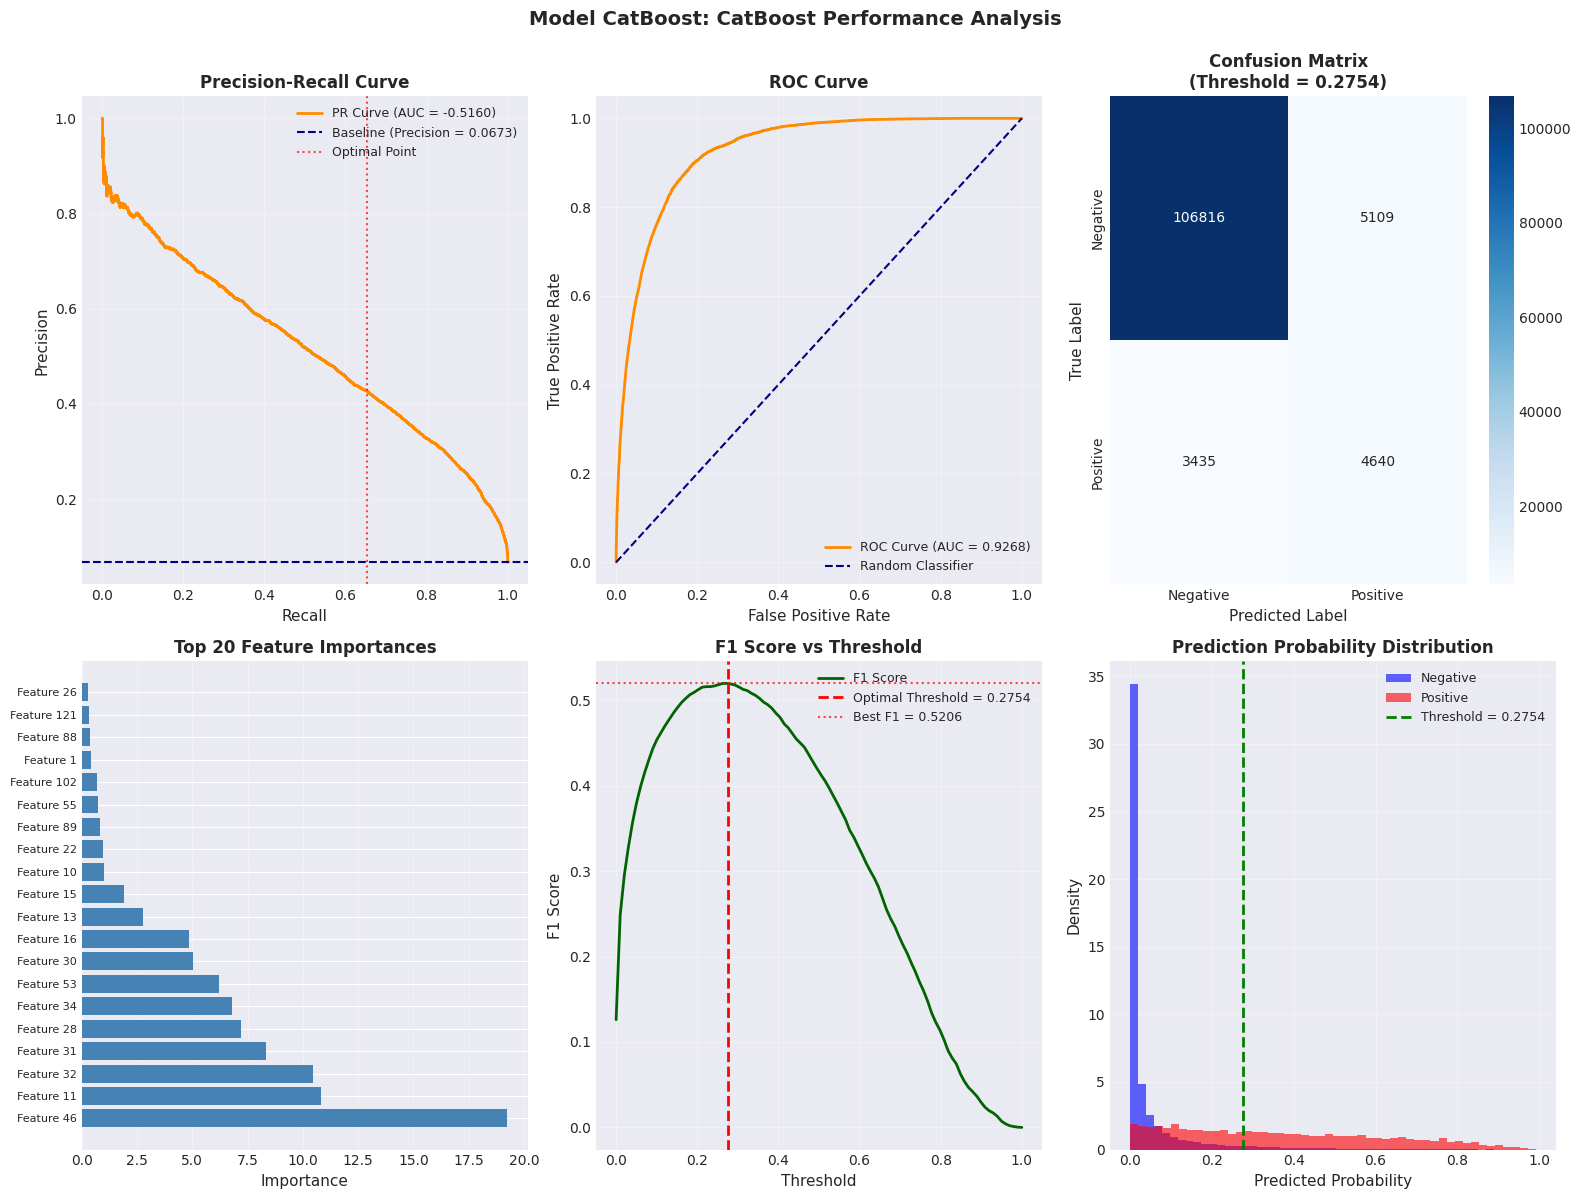

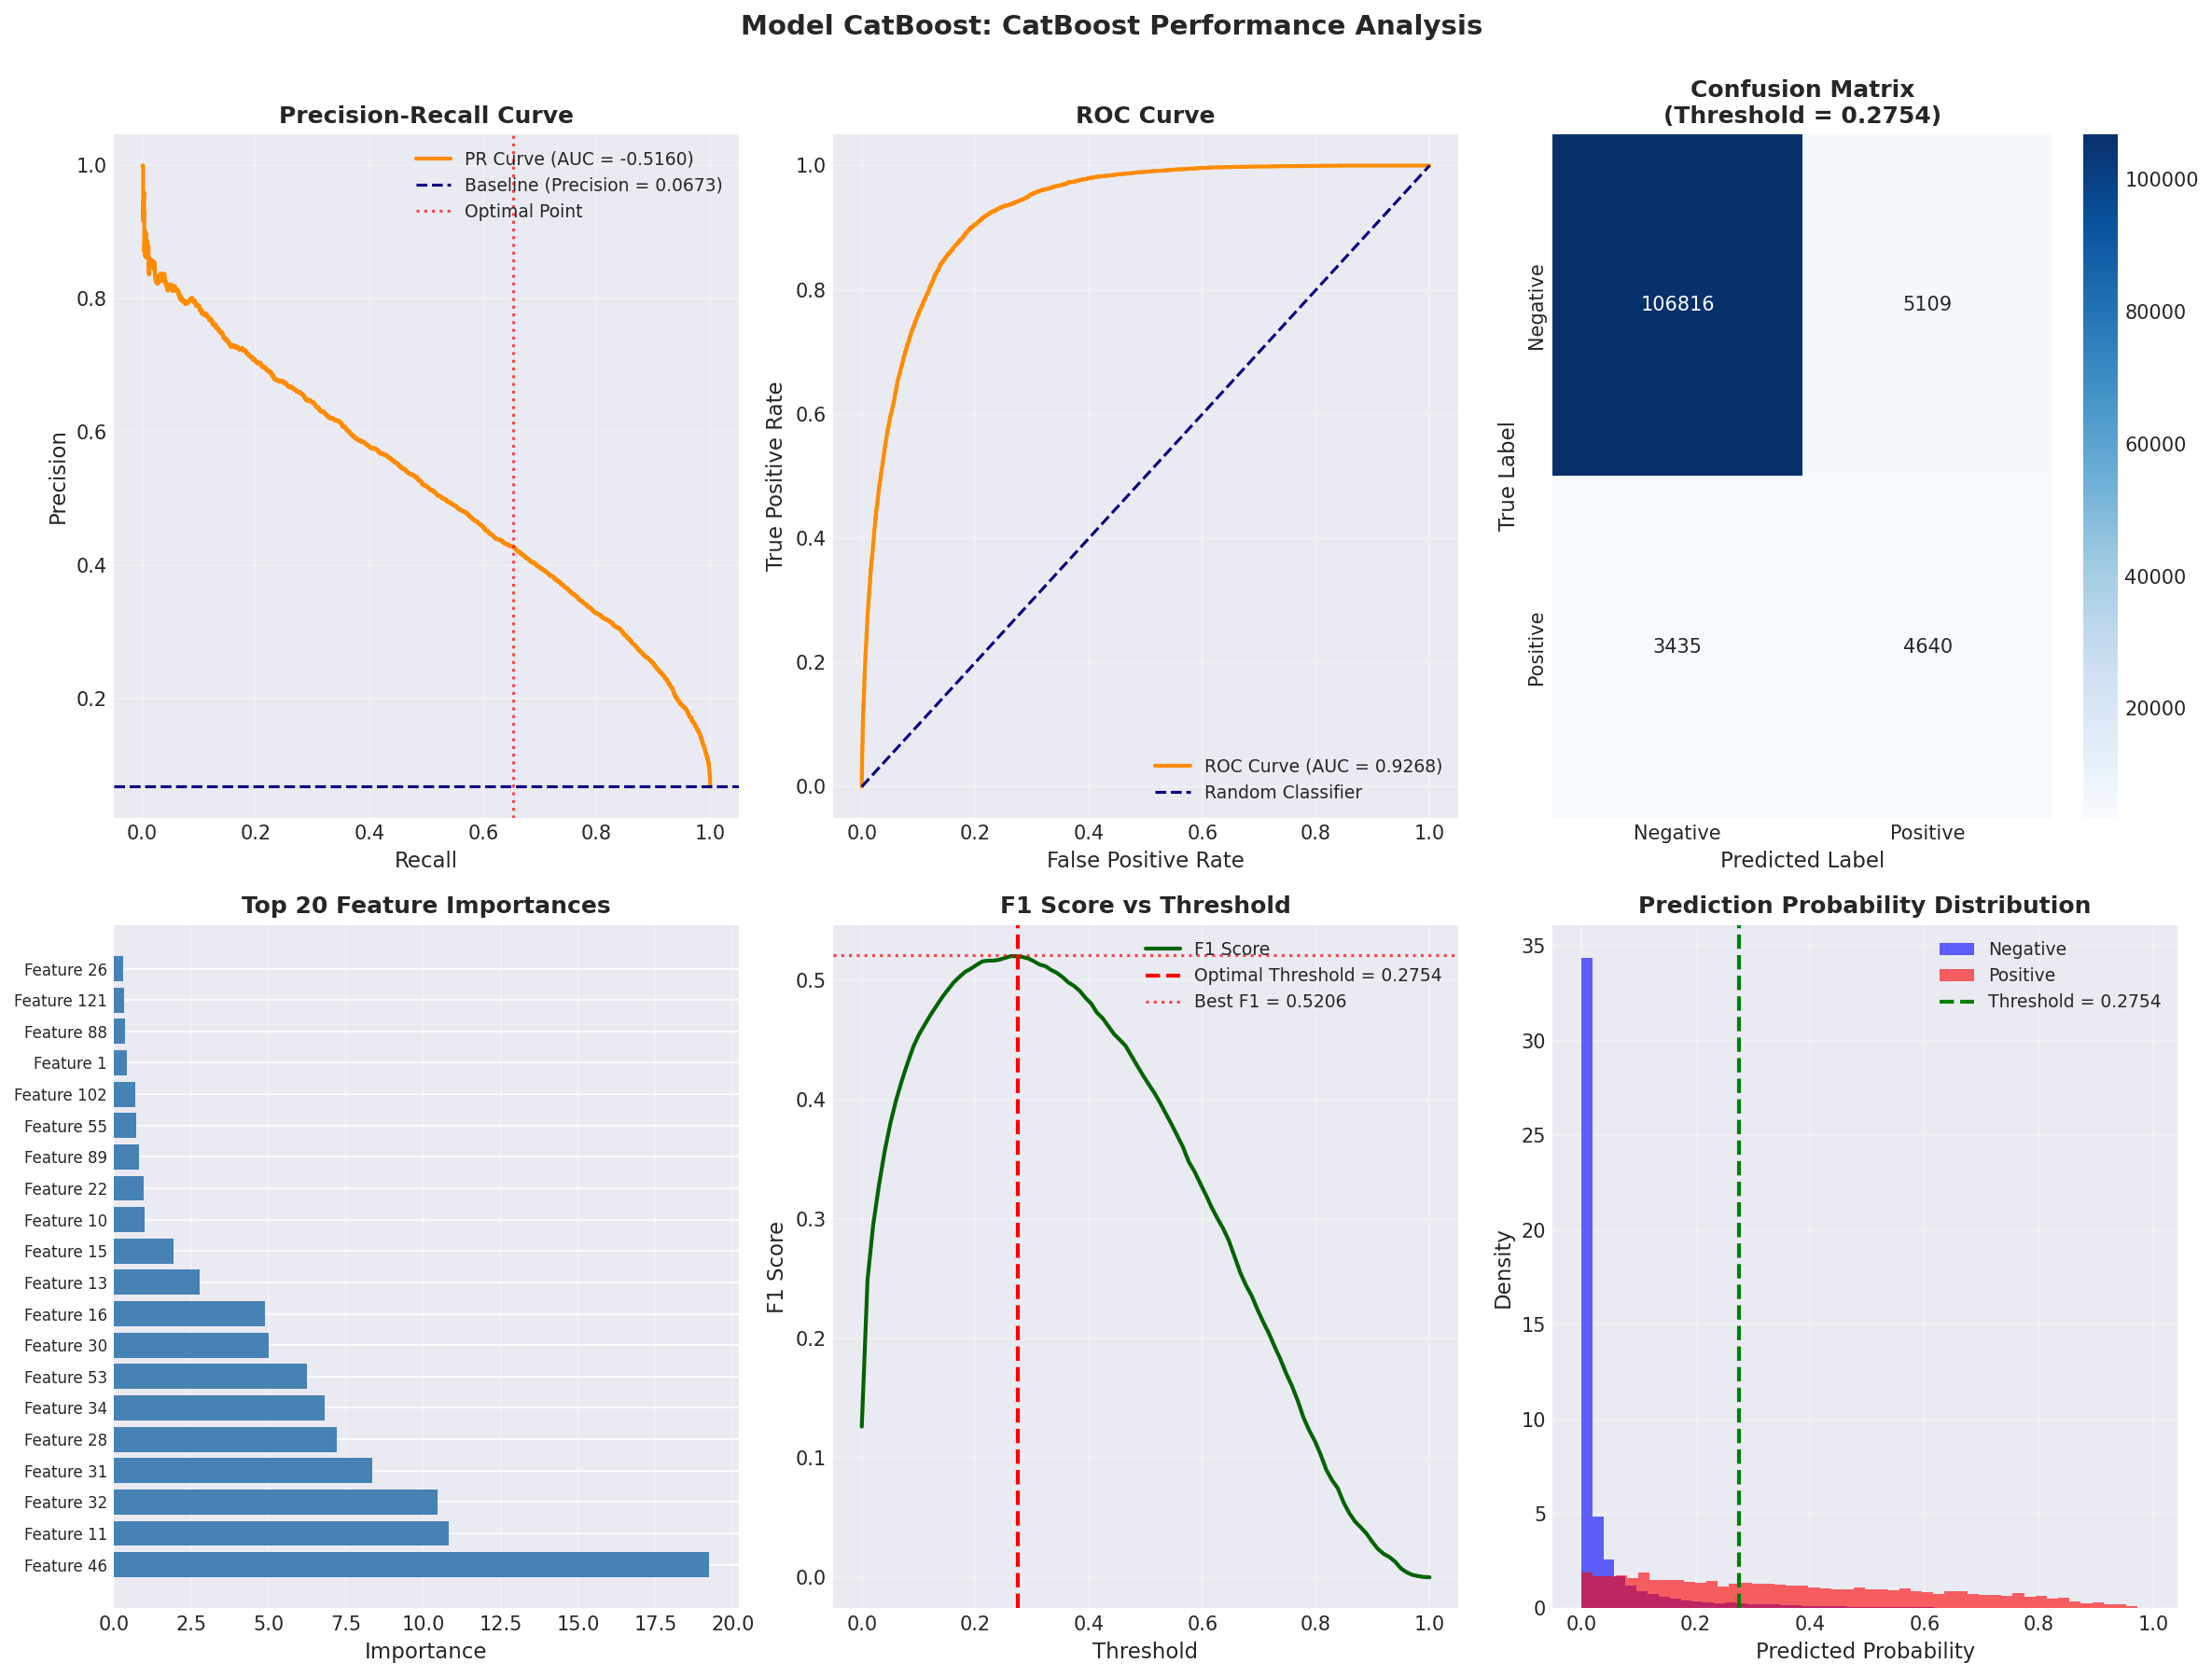

✅ Final performance plots saved to: logs/model_catboost_final_performance.png


In [17]:
# ============================================
# VISUALIZATION: Final Model Performance
# ============================================
try:
    print("\n" + "=" * 80)
    print("PLOTTING: Final Model Performance Visualizations")
    print("=" * 80)
    
    if 'final_model' in locals() and 'y_val_proba' in locals() and 'y_val' in locals():
        # Calculate curves
        precision, recall, pr_thresholds = precision_recall_curve(y_val, y_val_proba)
        fpr, tpr, roc_thresholds = roc_curve(y_val, y_val_proba)
        roc_auc = roc_auc_score(y_val, y_val_proba)
        pr_auc = np.trapz(precision, recall)
        
        # Create comprehensive figure
        fig = plt.figure(figsize=(16, 12))
        
        # 1. PR Curve
        ax1 = plt.subplot(2, 3, 1)
        ax1.plot(recall, precision, color='darkorange', lw=2, 
                label=f'PR Curve (AUC = {pr_auc:.4f})')
        ax1.axhline(y=y_val.mean(), color='navy', linestyle='--', 
                   label=f'Baseline (Precision = {y_val.mean():.4f})')
        ax1.axvline(x=recall[np.argmax(precision * recall)], color='red', linestyle=':', 
                   alpha=0.7, label=f'Optimal Point')
        ax1.set_xlabel('Recall', fontsize=11)
        ax1.set_ylabel('Precision', fontsize=11)
        ax1.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
        ax1.legend(loc='best', fontsize=9)
        ax1.grid(True, alpha=0.3)
        
        # 2. ROC Curve
        ax2 = plt.subplot(2, 3, 2)
        ax2.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC Curve (AUC = {roc_auc:.4f})')
        ax2.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Classifier')
        ax2.set_xlabel('False Positive Rate', fontsize=11)
        ax2.set_ylabel('True Positive Rate', fontsize=11)
        ax2.set_title('ROC Curve', fontsize=12, fontweight='bold')
        ax2.legend(loc='best', fontsize=9)
        ax2.grid(True, alpha=0.3)
        
        # 3. Confusion Matrix
        ax3 = plt.subplot(2, 3, 3)
        cm = confusion_matrix(y_val, y_val_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3, 
                   xticklabels=['Negative', 'Positive'], 
                   yticklabels=['Negative', 'Positive'])
        ax3.set_ylabel('True Label', fontsize=11)
        ax3.set_xlabel('Predicted Label', fontsize=11)
        ax3.set_title(f'Confusion Matrix\n(Threshold = {best_threshold:.4f})', 
                     fontsize=12, fontweight='bold')
        
        # 4. Feature Importance (Top 20)
        ax4 = plt.subplot(2, 3, 4)
        if hasattr(final_model, 'feature_importances_'):
            feature_importance = final_model.feature_importances_
            top_n = min(20, len(feature_importance))
            top_indices = np.argsort(feature_importance)[-top_n:][::-1]
            top_importance = feature_importance[top_indices]
            ax4.barh(range(top_n), top_importance, color='steelblue')
            ax4.set_yticks(range(top_n))
            ax4.set_yticklabels([f'Feature {i}' for i in top_indices], fontsize=8)
            ax4.set_xlabel('Importance', fontsize=11)
            ax4.set_title(f'Top {top_n} Feature Importances', fontsize=12, fontweight='bold')
            ax4.grid(True, alpha=0.3, axis='x')
        else:
            ax4.text(0.5, 0.5, 'Feature importance\nnot available', 
                    ha='center', va='center', transform=ax4.transAxes, fontsize=12)
            ax4.set_title('Feature Importance', fontsize=12, fontweight='bold')
        
        # 5. Threshold Analysis
        ax5 = plt.subplot(2, 3, 5)
        thresholds_fine = np.linspace(0, 1, 100)
        f1_scores_fine = []
        for thr in thresholds_fine:
            y_pred_thr = (y_val_proba >= thr).astype(int)
            f1_thr = f1_score(y_val, y_pred_thr, pos_label=1, zero_division=0)
            f1_scores_fine.append(f1_thr)
        ax5.plot(thresholds_fine, f1_scores_fine, color='darkgreen', lw=2, label='F1 Score')
        ax5.axvline(x=best_threshold, color='red', linestyle='--', lw=2, 
                   label=f'Optimal Threshold = {best_threshold:.4f}')
        ax5.axhline(y=best_f1, color='red', linestyle=':', alpha=0.7, 
                   label=f'Best F1 = {best_f1:.4f}')
        ax5.set_xlabel('Threshold', fontsize=11)
        ax5.set_ylabel('F1 Score', fontsize=11)
        ax5.set_title('F1 Score vs Threshold', fontsize=12, fontweight='bold')
        ax5.legend(loc='best', fontsize=9)
        ax5.grid(True, alpha=0.3)
        
        # 6. Prediction Distribution
        ax6 = plt.subplot(2, 3, 6)
        ax6.hist(y_val_proba[y_val == 0], bins=50, alpha=0.6, label='Negative', 
                color='blue', density=True)
        ax6.hist(y_val_proba[y_val == 1], bins=50, alpha=0.6, label='Positive', 
                color='red', density=True)
        ax6.axvline(x=best_threshold, color='green', linestyle='--', lw=2, 
                   label=f'Threshold = {best_threshold:.4f}')
        ax6.set_xlabel('Predicted Probability', fontsize=11)
        ax6.set_ylabel('Density', fontsize=11)
        ax6.set_title('Prediction Probability Distribution', fontsize=12, fontweight='bold')
        ax6.legend(loc='best', fontsize=9)
        ax6.grid(True, alpha=0.3)
        
        plt.suptitle('Model CatBoost: CatBoost Performance Analysis', fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout()
        final_plot_path = PROJECT_ROOT / 'logs' / 'model_catboost_final_performance.png'
        plt.savefig(final_plot_path, dpi=150, bbox_inches='tight')
        plt.show()  # Display plot in notebook
        display(Image(str(final_plot_path)))  # Display inline
        print("✅ Final performance plots saved to: logs/model_catboost_final_performance.png")
        plt.close()
        cleanup_memory()
    else:
        print("⚠️ Skipping final visualization (final_model or predictions not available)")
        
except Exception as e:
    print(f"⚠️ Error plotting final performance: {e}")
    import traceback
    traceback.print_exc()
    cleanup_memory()



## 8. Save Model

In [18]:
# Save model
try:
    model_save_path = MODEL_SAVE_DIR / "model_catboost_all_features_best.pkl"

    save_dict = {
        "model": final_model,
        "scaler": scaler if 'scaler' in locals() else None,
        "pca_models": pca_models_train if 'pca_models_train' in locals() else None,
        "best_params": best_params,
        "best_cv_score": best_cv_score,
        "best_threshold": best_threshold,
        "best_f1": best_f1,
        "reg_cols": reg_cols,
        "emb_family_to_cols": emb_family_to_cols,
    }

    with open(model_save_path, "wb") as f:
        pickle.dump(save_dict, f)

    print(f"\n💾 Model saved to: {model_save_path}")

except Exception as e:
    print(f"❌ Error saving model: {e}")



💾 Model saved to: /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/models/saved_models/model_catboost_all_features_best.pkl


## 9. Generate Submission

In [19]:
import re

def extract_work_id(id_value: str) -> str:
    """Extract work_id from URL or return as is if already just ID."""
    id_str = str(id_value)
    # If it already looks like a work ID, just return it
    if id_str.startswith('W') and len(id_str) > 1 and '/' not in id_str:
        return id_str
    # Otherwise, extract from URL or string
    match = re.search(r'W\d+', id_str)
    if match:
        return match.group(0)
    return id_str

# Load test data and generate predictions
try:
    print("\n" + "=" * 80)
    print("PHASE 7: Test Predictions")
    print("=" * 80)
    phase_start = time.time()
    print("Generating Test Predictions...")

    test_df = load_parquet_split("test")
    test_ids = test_df["id"].to_numpy()

    # Process test data same as train
    X_reg_test, X_emb_test_fams, _, _, _ = split_features_reg_and_all_emb(test_df)
    del test_df

    # Apply PCA
    X_emb_test_pca, _ = apply_pca_to_embeddings(
        X_emb_test_fams, fit_on_train=False, pca_models=pca_models_train
    )

    # Combine features
    if X_reg_test is not None:
        X_test = np.hstack([X_reg_test, X_emb_test_pca])
    else:
        X_test = X_emb_test_pca

    del X_reg_test, X_emb_test_fams, X_emb_test_pca
    cleanup_memory()

    # Scale
    if "scaler" in locals():
        X_test = scaler.transform(X_test)

    # Predict in chunks for Out Of Memory protection
    chunk_size = 10000
    if X_test.shape[0] > chunk_size:
        print(f"  Predicting in chunks (size={chunk_size}) for OOM protection...")
        y_test_proba_chunks = []
        for i in range(0, X_test.shape[0], chunk_size):
            chunk_proba = safe_prediction(final_model.predict_proba, X=X_test[i : i + chunk_size])[:, 1]
            y_test_proba_chunks.append(chunk_proba)
            del chunk_proba
            cleanup_memory()
        y_test_proba = np.concatenate(y_test_proba_chunks)
        del y_test_proba_chunks
    else:
        y_test_proba = safe_prediction(final_model.predict_proba, X=X_test)[:, 1]

    y_test_pred = (y_test_proba >= best_threshold).astype(int)

    # Create submission using Polars
    work_ids = np.array([extract_work_id(str(id_val)) for id_val in test_ids])
    submission_df = pl.DataFrame({"work_id": work_ids, "label": y_test_pred})

    submission_path = SUBMISSION_DIR / "submission_model_catboost.csv"
    submission_df.write_csv(submission_path)

    phase_time = time.time() - phase_start
    print(f"\n✅ Submission saved to: {submission_path}")
    print(f"  Test predictions: {len(y_test_pred)}, Positive: {y_test_pred.sum()}, Negative: {(y_test_pred==0).sum()}")
    print(f"\n⏱️  Test Predictions Time: {phase_time:.2f} seconds ({phase_time/60:.2f} minutes)")

    cleanup_memory()
    memory_usage()
    
    # Print total execution time summary
    total_time = time.time() - TOTAL_START_TIME
    print(f"\n{'='*80}")
    # Print total execution time summary
    total_time = time.time() - TOTAL_START_TIME
    END_TIME_STR = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print(f"\n{'='*80}")
    print(f"MODEL_CATBOOST EXECUTION COMPLETED")
    print(f"Start Time: {START_TIME_STR}")
    print(f"End Time: {END_TIME_STR}")
    print(f"Total Execution Time: {total_time:.2f} seconds ({total_time/60:.2f} minutes / {total_time/3600:.2f} hours)")
    print(f"Final Validation F1 Score: {best_f1:.4f}")
    print(f"{'='*80}\n")
    print(f"End Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Final Validation F1 Score: {best_f1:.4f}")
    print(f"{'='*80}\n")

except Exception as e:
    total_time = time.time() - TOTAL_START_TIME
    print(f"\n❌ Error generating submission: {e}")
    print(f"Execution failed after {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
    raise



PHASE 7: Test Predictions
Generating Test Predictions...
Loading test from /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/model_ready/test_model_ready.parquet


✅ Checkpoint saved: /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/checkpoints/model_catboost_checkpoint_pca.pkl


  Predicting in chunks (size=10000) for OOM protection...



✅ Submission saved to: /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/submission_files/submission_model_catboost.csv
  Test predictions: 120000, Positive: 9727, Negative: 110273

⏱️  Test Predictions Time: 42.65 seconds (0.71 minutes)


💾 Memory: 36.05 GB (RAM) | 0.00/0.00 GB (GPU used/reserved)


MODEL_CATBOOST EXECUTION COMPLETED
Start Time: 2025-11-19 09:44:46
End Time: 2025-11-19 10:21:19
Total Execution Time: 2192.43 seconds (36.54 minutes / 0.61 hours)
Final Validation F1 Score: 0.5206

End Time: 2025-11-19 10:21:19
Final Validation F1 Score: 0.5206

